<br><br>
<font size='6'><b>Recurrent Neural Network
</b></font><br><br>

<table style="border-style: hidden; border-collapse: collapse;" width = "80%"> 
    <tr style="border-style: hidden; border-collapse: collapse;">
        <td width = 40% style="border-style: hidden; border-collapse: collapse;">

        </td>
        <td width = 40%>
        By Prof. Seungchul Lee<br>iSystems Design Lab<br>http://isystems.unist.ac.kr/<br>UNIST
        </td>
    </tr>
</table>

Table of Contents
<div id="toc"></div>

# 1. Recurrent Neural Network (RNN)
- RNNs are a family of neural networks for processing sequential data

## 1.1. Feedforward Network and Sequential Data

<br>
<img src="./image_files/sequence_layer.png" width = 400>
<br>

- Separate parameters for each value of the time index
    - Cannot share statistical strength across different time index

In [1]:
%%html
<center><iframe src="https://www.youtube.com/embed/oYglxfBtSQk" 
width="560" height="315" frameborder="0" allowfullscreen></iframe></center>

<br>
<img src="./image_files/ball_rolling.png" width = 400>
<br>

## 1.2. Structure of RNN

__ Recurrence __
- It is possible to use the __same__ transition function $f$ with the same parameters at every time step

<br>
<img src="./image_files/sequence_layer_dependv2.png" width = 370>
<br>

__ Hidden State __
- Lossy summary of the the past sequence of inputs up to $t$
- Keep some aspects of the past sequence with more precision than other aspects
- Network learns the function $f$
$$  h^{(t)} = f\left(h^{(t-1)}, x^{(t)}\right) $$
$$ f\left(h^{(t-1)}, x^{(t)}\right) = g\left(Wx_{t} + Uh_{t-1}\right) $$



<table style="border-style: hidden; border-collapse: collapse;" width = "96%"> 
    <tr style="border-style: hidden; border-collapse: collapse;">
        <td width = 48% style="border-style: hidden; border-collapse: collapse;">
<img src="./image_files/micro_view_rnn.png" width = 400>
        </td>
        <td width = 48%>
<img src="./image_files/recurrence_gif.gif" width = 400>
        </td>
    </tr>
</table>
<br>

__ Deep Recurrent Networks __
- Three blocks of parameters and associated transformation
    1. From the input to the hidden state (from green to yellow)
    2. From the previous hidden state to the next hidden state (from yellow to red)
    3. From the hidden state to the output (from red to blue)
    
<br>
<img src="./image_files/deep_RNN.PNG" width = 300>
<br>

## 1.3. RNN with LSTM

__ Long-Term Dependencies __
- Gradients propagated over many stages tend to either vanish or explode
- Difficulty with long-term dependencies arises from the exponentially smaller weights given to long-term interactions

<br>
<img src="./image_files/vanishing_gradient.png" width = 550>
<br>

__ Long Short-Term Memory (LSTM) __
- Allow the network to __accumulate__ information over a long duration
- Once that information has been used, it might be use for the neural network to __forget__ the old state

<br>
<img src="./image_files/gates_lstm.png" width = 550>
<br>
<img src="./image_files/LSTM3-var-GRU.png" width = 550>


__ Summary __
- Connect LSTM cells in a recurrent manner
- Train parameters in LSTM cells

## 1.4. RNN and Sequential Data
Time Series Data Classification
<br>
<img src="./image_files/RNN_Structure.png" width = 450>
<br>

Time Series Data Prediction
<br>
<img src="./image_files/rnn_predict_edit.png" width = 450>
<br>

# 2. RNN with Tensorflow

- Will predict a future time signal
- Regression problem

## 2.1. Import Library

In [2]:
import tensorflow as tf
from six.moves import cPickle
import numpy as np
import matplotlib.pyplot as plt

## 2.2. Load Time Signal Data
- Import acceleration data of rotation machinery

(41000,)


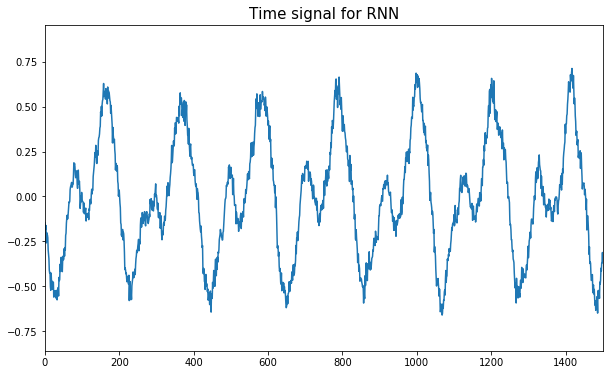

In [3]:
data =  cPickle.load(open('./data_files/rnn_time_signal_downsample.pkl', 'rb'))

print(data.shape)
plt.figure(figsize=(10, 6))
plt.title('Time signal for RNN', fontsize=15)
plt.plot(data)
plt.xlim(0,1500)
plt.show()

## 2.3. Define RNN Structure

<br>
<img src="./image_files/RNN_ac_edit_2.png" width = 650>
<br>

In [4]:
## 1100 data points are used for each iteration
n_step = 10
n_input = 100

## LSTM shape
n_lstm1 = 100
n_lstm2 = 100

## Fully connected
n_hidden = 100
n_output = 100

## 2.4. Define Weights and Biases

__LSTM Cell__
- Do not need to define weights of lstm cells

__ Fully connected__
- Define parameters based on the predefined layer size
- Initialize with a normal distribution with $\mu = 0$ and $\sigma = 0.01$


In [5]:
weights = {
    'hidden' : tf.Variable(tf.random_normal([n_lstm2, n_hidden], stddev=0.01)),
    'output' : tf.Variable(tf.random_normal([n_hidden, n_output], stddev=0.01))
}

biases = {
    'hidden' : tf.Variable(tf.random_normal([n_hidden], stddev=0.01)),
    'output' : tf.Variable(tf.random_normal([n_output], stddev=0.01))
}

x = tf.placeholder(tf.float32, [None, n_step, n_input])
y = tf.placeholder(tf.float32, [None, n_output])

## 2.5. Build Model

__ Build RNN Network __
- First, define LSTM cell
```python
lstm = tf.contrib.rnn.BasicLSTMCell(n_lstm)
```
- Second, compute hidden state (h) and lstm cell (c) with predefined lstm cell and input
```python
h, c = tf.nn.dynamic_rnn(lstm, input_tensor, dtype=tf.float32)
```

In [6]:
def build_model(x, weights, biases):
    with tf.variable_scope('rnn'):
        # Build RNN network
        with tf.variable_scope('lstm1'):            
            lstm1 = tf.contrib.rnn.BasicLSTMCell(n_lstm1)
            h1, c1 = tf.nn.dynamic_rnn(lstm1, x, dtype=tf.float32)
        with tf.variable_scope('lstm2'):            
            lstm2 = tf.contrib.rnn.BasicLSTMCell(n_lstm2)
            h2, c2 = tf.nn.dynamic_rnn(lstm2, h1, dtype=tf.float32)
            
        # Build classifier
        hidden = tf.add(tf.matmul(h2[:,-1,:], weights['hidden']), biases['hidden'])
        hidden = tf.nn.relu(hidden)
        output = tf.add(tf.matmul(hidden, weights['output']), biases['output'])
        return output

## 2.6. Define Cost, Initializer and Optimizer
__Loss__

- Regression : Squared loss
$$ \frac{1}{N} \sum_{i=1}^{N}  (\hat{y}^{(i)} - y^{(i)})^2$$

__Initializer__
- Initialize all the empty variables
    
__Optimizer__
- AdamOptimizer : The most popular optimizer

In [7]:
LR = 0.0002

pred = build_model(x, weights, biases)
loss = tf.square(tf.subtract(y, pred))
loss = tf.reduce_mean(loss)

optm = tf.train.AdamOptimizer(LR).minimize(loss)

init = tf.global_variables_initializer()

## 2.7. Summary of Model

<br>
<img src="./image_files/cnn_summary of model.png" width = 500>
<br>

## 2.7. Define Configuration

- Define parameters for training RNN
     - n_iter : the number of training steps
     - n_prt : check loss for every n_prt iteration

In [8]:
n_iter = 2500
n_prt = 250
stride = 5

## 2.8. Optimization

In [9]:
# Run initialize
# config = tf.ConfigProto(allow_soft_placement=True)  # GPU Allocating policy
# sess = tf.Session(config=config)
sess = tf.Session()
sess.run(init)

for i in range(n_iter):
    train_x = data[i*stride:i*stride + n_step*n_input]
    train_x = train_x.reshape(n_step, n_input)
    train_x = train_x[np.newaxis,:]
    
    train_y = data[i*stride + n_step*n_input:i*stride + n_step*n_input + n_output]
    train_y = train_y[np.newaxis,:]
    
    sess.run(optm, feed_dict={x: train_x,  y: train_y})
    c = sess.run(loss, feed_dict={x: train_x,  y: train_y})
    if i % n_prt == 0:
        print ("Iter : {}".format(i))
        print ("Cost : {}".format(c))

Iter : 0
Cost : 0.17856281995773315
Iter : 250
Cost : 0.13783246278762817
Iter : 500
Cost : 0.08335303515195847
Iter : 750
Cost : 0.0762801468372345
Iter : 1000
Cost : 0.022565532475709915
Iter : 1250
Cost : 0.0036730391439050436
Iter : 1500
Cost : 0.00793518591672182
Iter : 1750
Cost : 0.08607370406389236
Iter : 2000
Cost : 0.0031480693724006414
Iter : 2250
Cost : 0.015131507068872452


## 2.9. Test
- Predict a future time signal

- `data[0:13600]` are used for learning (5$\times$2500 + 1100 = 13600)

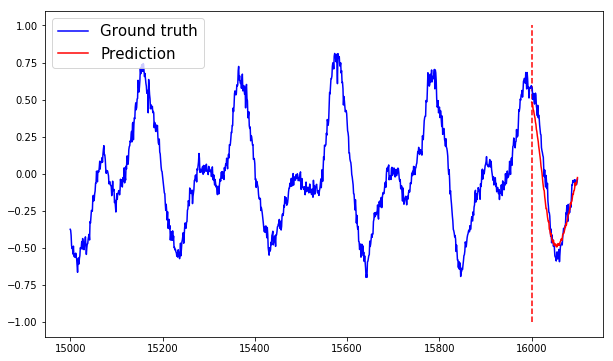

In [10]:
start_pt = 15000

test_range = [start_pt, start_pt + n_step*n_input]
pred_range = [test_range[1], test_range[1] + n_input]
GT_range = [start_pt, pred_range[1]]

test_x = data[test_range[0]:test_range[1]]
test_x = test_x.reshape(n_step, n_input)
test_x = test_x[np.newaxis,:]

ground_truth = data[GT_range[0]:GT_range[1]]

test_pred = sess.run(pred, feed_dict={x : test_x})

plt.figure(figsize=(10, 6))
plt.plot(np.arange(GT_range[0], GT_range[1]), \
         ground_truth, 'b', label='Ground truth')
plt.plot(np.arange(pred_range[0], pred_range[1]), \
         test_pred.ravel(), 'r', label='Prediction')
plt.vlines(pred_range[0], -1, 1, colors = 'r', linestyles='dashed')
plt.legend(fontsize=15, loc='upper left')
plt.show()

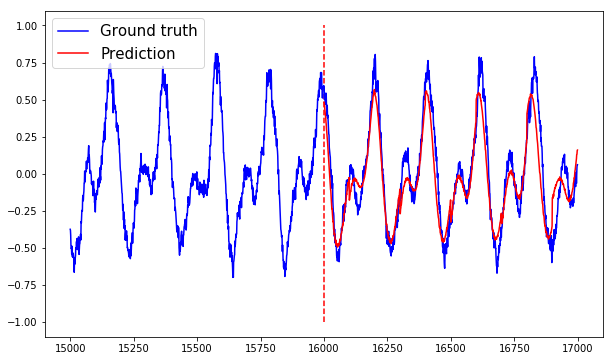

In [11]:
start_pt = 15000

test_range = [start_pt, start_pt + n_step*n_input]
pred_range = [test_range[1], test_range[1] + n_step*n_input]
GT_range = [start_pt, pred_range[1]]

test_x = data[test_range[0]:test_range[1]]
test_x = test_x.reshape(n_step, n_input)
test_x = test_x[np.newaxis,:]

ground_truth = data[GT_range[0]:GT_range[1]]

gen_signal = []
for i in range(n_step):
    test_pred = sess.run(pred, feed_dict={x : test_x})
    gen_signal.append(test_pred.ravel())
    test_pred = test_pred[:,np.newaxis,:]
    
    test_x = test_x[:,1:,:]
    test_x = np.concatenate([test_x, test_pred], axis=1)
    
gen_signal = np.concatenate(gen_signal)

plt.figure(figsize=(10,6))
plt.plot(np.arange(GT_range[0], GT_range[1]), \
         ground_truth, 'b', label='Ground truth')
plt.plot(np.arange(pred_range[0], pred_range[1]), \
         gen_signal, 'r', label='Prediction')
plt.vlines(pred_range[0], -1, 1, colors = 'r', linestyles='dashed')
plt.legend(fontsize=15, loc='upper left')
plt.show()

In [12]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>